In [2]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
import warnings
# warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Load sub from Myspeedup: 100%|██████████| 37/37 [00:17<00:00, 130.81it/s]

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,5.843285e+06,5.834129e+06,1.001569,30473,99.90545
1,1,1024,RING,3.004332e+06,2.994255e+06,1.003365,30473,99.90545
2,2,1024,RING,5.157804e+05,5.141424e+05,1.003186,30473,99.90545
3,3,1024,RING,2.088437e+05,2.075790e+05,1.006092,30473,99.90545
4,4,1024,RING,5.047996e+04,4.939200e+04,1.022027,30473,99.90545
5,5,1024,RING,1.395449e+04,1.359446e+04,1.026484,30473,99.90545


Model summary:
==============

                  N
Point sources     0
Extended sources  2
Particle sources  0

Free parameters (4):
--------------------

                                         value min_value max_value   
J0056P6346u.spectrum.main.Powerlaw.K       0.0       0.0       0.0  \
J0056P6346u.spectrum.main.Powerlaw.index -2.35     -3.65     -1.05   
Diffuse.spectrum.main.Powerlaw.K           0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index      -2.5      -4.5      -0.5   

                                                    unit  
J0056P6346u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J0056P6346u.spectrum.main.Powerlaw.index                  
Diffuse.spectrum.main.Powerlaw.K          keV-1 s-1 cm-2  
Diffuse.spectrum.main.Powerlaw.index                      

Fixed parameters (8):
---------------------

                                                                                    value   
J0056P6346u.Gaussian_on_sphere.lon0                                                 13.78  \
J0056P6346u.Gaussian_on_sphere.lat0                                                 63.96   
J0056P6346u.Gaussian_on_sphere.sigma                                                 0.33   
J0056P6346u.spectrum.main.Powerlaw.piv                                       3000000000.0   
Diffuse.SpatialTemplate_2D.K                                                          1.0   
Diffuse.SpatialTemplate_2D.hash         1855488267240078630152078200584812694466364620...   
Diffuse.SpatialTemplate_2D.ihdu                                                       0.0   
Diffuse.spectrum.main.Powerlaw.piv                                           3000000000.0   

                                       min_value max_value   unit  
J0056P6346u.Gaussian_on_sphere.lon0        13.03     14.53    deg  
J0056P6346u.Gaussian_on_sphere.lat0        63.21     64.71    deg  
J0056P6346u.Gaussian_on_sphere.sigma         0.0      0.68    deg  
J0056P6346u.spectrum.main.Powerlaw.piv      None      None    keV  
Diffuse.SpatialTemplate_2D.K                None      None  deg-2  
Diffuse.SpatialTemplate_2D.hash             None      None         
Diffuse.SpatialTemplate_2D.ihdu              0.0      None         
Diffuse.spectrum.main.Powerlaw.piv          None      None    keV  

Properties (2):
--------------------

                                                                                  value   
Diffuse.SpatialTemplate_2D.fits_file  ../../data/Diffuse_WCDA_case11_dust_bkg_templa...  \
Diffuse.SpatialTemplate_2D.frame                                                   icrs   

                                                            allowed values  
Diffuse.SpatialTemplate_2D.fits_file                                  None  
Diffuse.SpatialTemplate_2D.frame      [icrs, galactic, fk5, fk4, fk4_no_e]  

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Best fit values:

,result,unit
parameter,,
J0056P6346u.spectrum.main.Powerlaw.K,(1.557 -0.028 +0.029) x 10^-22,1 / (keV s cm2)
J0056P6346u.spectrum.main.Powerlaw.index,-2.461 +/- 0.010,
Diffuse.spectrum.main.Powerlaw.K,(0.0 +/- 2.3) x 10^6,1 / (keV s cm2)
Diffuse.spectrum.main.Powerlaw.index,(-0 +/- 9) x 10,


Correlation matrix:

1.00,-0.05,-0.04,-0.04
-0.05,1.00,0.00,0.00
-0.04,0.00,1.00,1.00
-0.04,0.00,1.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA,14702.159153
total,14702.159153


Values of statistical measures:

,statistical measures
AIC,29412.318524
BIC,29452.783729


Smoothing planes:   0%|          | 0/6 [00:00<?, ?it/s]


WARNING RuntimeWarning: invalid value encountered in sqrt



(10.647321428571429, 58.91977535280315)


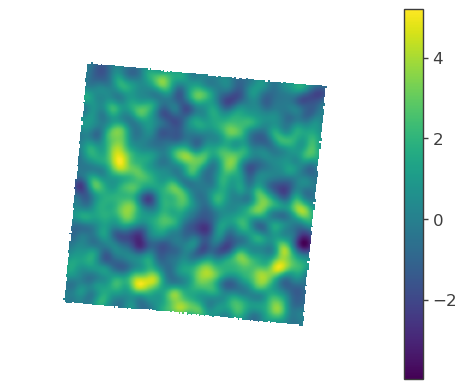

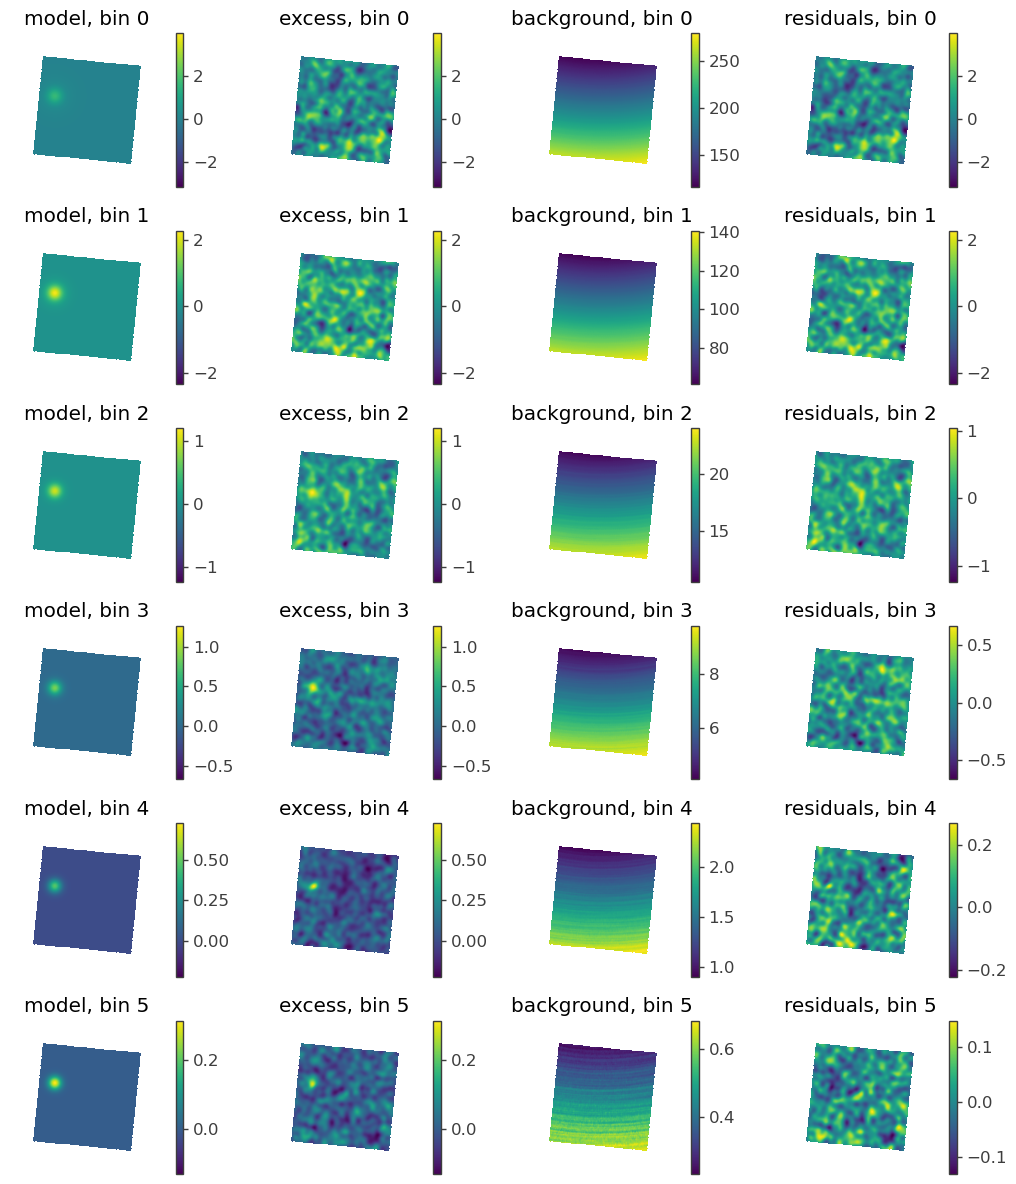

<Figure size 640x480 with 0 Axes>

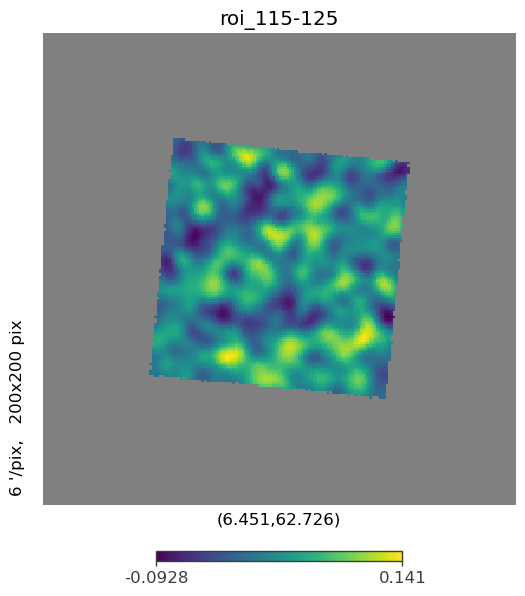

LHAASO:  1 1.86 57.0  1LHAASO J0007+5659u  0.0
LHAASO:  2 1.86 57.0  1KM2A J0007+5659u  0
LHAASO:  3 14.1 63.77  1LHAASO J0056+6346u  0.24
LHAASO:  4 13.78 63.96  1LHAASO J0056+6346u   0.33
TeVCat:  1 6.34 64.13 Tycho 0.0
TeVCat:  2 8.82 59.79 1ES 0033+595 0.0
PSR:  1 6.710666666666667 63.33358333333334 J0026+6320
PSR:  2 8.25 57.0 J0033+57
PSR:  3 8.25 61.0 J0033+61
PSR:  4 8.499999999999998 69.71666666666667 J0034+69
PSR:  5 10.134833333333333 57.273583333333335 J0040+5716
PSR:  6 13.249999999999998 69.65 J0053+69
PSR:  7 13.499999999999998 66.0 J0054+66
PSR:  8 13.616666666666665 69.43333333333334 J0054+69
PSR:  9 14.499999999999998 61.416666666666664 J0058+6125
PSR:  10 15.637333333333334 65.62038888888888 J0102+6537
PSR:  11 17.094333333333328 66.14277777777778 J0108+6608
PSR:  12 17.122916666666665 69.09794444444444 J0108+6905
PSR:  13 17.999999999999996 66.36666666666666 J0112+66
PSR:  14 19.41108333333333 59.244 J0117+5914
PSR:  15 21.499999999999996 62.583333333333336 J0125+62

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-1.4 +/- 3.5) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2580.697813
total,2580.697813


Values of statistical measures:

,statistical measures
AIC,5163.395647
BIC,5173.511981


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.256951 +/- 0.000016) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2655.86707
total,2655.86707


Values of statistical measures:

,statistical measures
AIC,5313.734163
BIC,5323.850497


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(1.2 +/- 1.0) x 10^-20,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2655.385269
total,2655.385269


Values of statistical measures:

,statistical measures
AIC,5312.770560
BIC,5322.886894


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.2570 +/- 0.0006) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2412.398903
total,2412.398903


Values of statistical measures:

,statistical measures
AIC,4826.797829
BIC,4836.914163


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.26 +/- 0.10) x 10^-20,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2412.132872
total,2412.132872


Values of statistical measures:

,statistical measures
AIC,4826.265766
BIC,4836.382100


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3 +/- 4) x 10^-20,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2412.11295
total,2412.11295


Values of statistical measures:

,statistical measures
AIC,4826.225922
BIC,4836.342256


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-2.2570 +/- 0.0015) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.76389
total,2476.76389


Values of statistical measures:

,statistical measures
AIC,4955.527801
BIC,4965.644135


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.2570 +/- 0.0006) x 10^-22,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.795059
total,2476.795059


Values of statistical measures:

,statistical measures
AIC,4955.590139
BIC,4965.706473


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0.2 +/- 1.3) x 10^-22,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792462
total,2476.792462


Values of statistical measures:

,statistical measures
AIC,4955.584945
BIC,4965.701279


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 4) x 10^-23,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792201
total,2476.792201


Values of statistical measures:

,statistical measures
AIC,4955.584424
BIC,4965.700758


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2 +/- 4) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792175
total,2476.792175


Values of statistical measures:

,statistical measures
AIC,4955.584372
BIC,4965.700706


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 8) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792172
total,2476.792172


Values of statistical measures:

,statistical measures
AIC,4955.584366
BIC,4965.700700


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 10) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792172
total,2476.792172


Values of statistical measures:

,statistical measures
AIC,4955.584366
BIC,4965.700700


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 6) x 10^-26,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792172
total,2476.792172


Values of statistical measures:

,statistical measures
AIC,4955.584366
BIC,4965.700700


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 6) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2476.792172
total,2476.792172


Values of statistical measures:

,statistical measures
AIC,4955.584366
BIC,4965.700700


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-2.2570 +/- 0.0035) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.237732
total,2369.237732


Values of statistical measures:

,statistical measures
AIC,4740.475486
BIC,4750.591820


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.2570 +/- 0.0010) x 10^-22,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.254362
total,2369.254362


Values of statistical measures:

,statistical measures
AIC,4740.508746
BIC,4750.625080


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0.2 +/- 1.9) x 10^-22,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.252995
total,2369.252995


Values of statistical measures:

,statistical measures
AIC,4740.506012
BIC,4750.622346


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0.2 +/- 3.1) x 10^-23,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.252858
total,2369.252858


Values of statistical measures:

,statistical measures
AIC,4740.505737
BIC,4750.622071


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 7) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.252844
total,2369.252844


Values of statistical measures:

,statistical measures
AIC,4740.505710
BIC,4750.622044


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0.2 +/- 1.0) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.252842
total,2369.252842


Values of statistical measures:

,statistical measures
AIC,4740.505707
BIC,4750.622041


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0 +/- 6) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.252842
total,2369.252842


Values of statistical measures:

,statistical measures
AIC,4740.505707
BIC,4750.622041


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(0.0 +/- 3.5) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2369.252842
total,2369.252842


Values of statistical measures:

,statistical measures
AIC,4740.505707
BIC,4750.622040


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-2.257 +/- 0.005) x 10^-21,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2206.540109
total,2206.540109


Values of statistical measures:

,statistical measures
AIC,4415.080241
BIC,4425.196575


In [15]:
%matplotlib inline
#####   Data Initialize
# activate_warnings()

# maptree = "../../data/gcd_new.root"
# response="../../data/WCDA_DR_psf.root"

# maptree =  "../../data/hsc2healpix_20210305_20220930.root"
# response = "../../data/WCDA_DR2.root"

# maptree =  "../../data/20210305_20230731_ihep_no_goodlist.root"
# response = "../../data/DR_ihep_MK2.root"

# maptree =  "../../data/20210305_20230731_ihep_goodlist.root"
# response = "../../data/DR_ihep_MK2_newpsf.root"

maptree =  "../../data/20210305-20230731_trans_fromhsc.root"
response = "../../data/DR_ihep_MK2_newoldDRpsf.root"


region_name="Diffuse_WCDA_case11"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')


nside=2**10
npix=hp.nside2npix(nside)
pixarea = 4 * np.pi/npix
pixIdx = hp.nside2npix(nside) # number of pixels I can get from this nside
pixIdx = np.arange(pixIdx) # pixel index numbers
new_lats = hp.pix2ang(nside, pixIdx)[0] # thetas I need to populate with interpolated theta values
new_lons = hp.pix2ang(nside, pixIdx)[1] # phis, same
c_icrs = SkyCoord(ra=new_lons*180/np.pi*u.degree, dec=90*u.degree-new_lats*180/np.pi*u.degree, frame='icrs')
c_l=c_icrs.galactic.l.deg
c_b=c_icrs.galactic.b.deg

resultsall = []
for i,gl in enumerate([120]): # #!!!!!!!!!!!!!!!!!!!365  range(20,360,10)
    c_gal = SkyCoord(l=(gl)*u.degree, b=0*u.degree, frame='galactic')
    RA_center=c_gal.icrs.ra.deg
    Dec_center=c_gal.icrs.dec.deg
    if (Dec_center<-20. or Dec_center>80.): continue
    signal=np.zeros(npix,dtype=np.float64)
    mask = ( (c_l< gl + 5) & (c_l > gl - 5) & (c_b <5.) & (c_b>-5) & (90-new_lats/np.pi*180>-20) & (90-new_lats/np.pi*180<80)) #&(new_lats<110/180*np.pi )  & (new_lats > 10/180*np.pi )
        
    signal[mask]=1
    # hp.mollview(signal,title="ROI",norm='hist')
    # hp.graticule()
    ra1,dec1=RA_center, Dec_center

    data_radius = 7
    model_radius = 7.5

    roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=signal)

    WCDA = HAL("WCDA", maptree, response, roi, flat_sky_pixels_size=0.17)

    #####   Data Situation
    %matplotlib inline
    WCDA.set_active_measurements(0, 5)
    WCDA.display()
    WCDA.psf_integration_method="exact"

    my.settransWCDA(WCDA, ra1, dec1)

    Modelname=f"roi_{gl - 5}-{gl + 5}"
    if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
        os.system(f'mkdir ../res/{region_name}/{Modelname}/')
    fig = WCDA.display_stacked_image(smoothing_kernel_sigma=0.25)
    fig.savefig(f"../res/{region_name}/{Modelname}_counts_all.png",dpi=300)

    lm = my.getcatModel(ra1, dec1, data_radius, model_radius, rtsigma=5, rtflux=20, rtindex=10, rtp=5,  detector="WCDA", roi=roi, pf=True, sf=True, kf=False, indexf=False,  mkf=True, mindexf=True,  setdeltabypar=True) #indexb=(-4,-1),

    Diffuse, diffscaleratio = my.set_diffusebkg(
                ra1, dec1, 8, 8, Kf=False, indexf=False, name=region_name, ifreturnratio=True, Kb=(1e-18, 1e-10), indexb=(-4.5, -0.5), index=-2.5, K=1e-12
                ) #Kn=1
    
    lm.add_source(Diffuse)

    lm.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
    lm.display(complete=True)

    result = my.fit(region_name, Modelname, WCDA, lm, 0, 5, mini="ROOT", donwtlimit=True) #, ifgeterror=True
    sources = my.get_sources(lm,result)
    resultsall.append([result, sources, diffscaleratio])

    resu = my.getressimple(WCDA, lm)
    new_source_idx = np.where(resu==np.ma.max(resu))[0][0]
    new_source_lon_lat=hp.pix2ang(1024,new_source_idx,lonlat=True)
    print(new_source_lon_lat)

    plt.figure()
    hp.gnomview(resu,norm='',rot=[ra1,dec1],xsize=200,ysize=200,reso=6,title=Modelname)
    plt.scatter(new_source_lon_lat[0],new_source_lon_lat[1],marker='x',color='red')
    plt.show()
    plt.savefig(f"../res/{region_name}/{Modelname}_res.png",dpi=300)

    map2, skymapHeader = hp.read_map("../../data/fullsky_WCDA_llh-2.6.fits.gz",h=True)
    map2 = my.maskroi(map2, roi)
    sources.pop("Diffuse")
    fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[10000],save=1, 
                    color="Fermi",
                    colors = my.colorall
                    )
    # try:
    Flux_WCDA0, jls0  = my.getdatapoint(WCDA, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, iffixtans=1)
    import matplotlib as mpl

    x_Max=50.
    x_Min=1
    y_Min=0.8e-13
    y_Max=2e-10
    fig,ax = plt.subplots()
    plot_spectra(
        result[0].results,
        sources_to_use=["Diffuse"], #,"ext1","ext2","ext4","ext5","ext6","ext7"|
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit="TeV/(s cm2)",
        subplot=ax,
        )

    my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA0,"Diffuse","tab:red")

    ax.set_xlim(x_Min,x_Max)
    ax.set_ylim(y_Min,y_Max)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
    ax.set_xlabel("Energy [TeV]")
    plt.legend()
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')
    # except:   pass
    #     continue

roi_15-25


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_25-35


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_35-45


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_45-55


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_55-65


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_65-75


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_75-85


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_85-95
roi_95-105
roi_105-115
roi_115-125
roi_125-135
roi_135-145
roi_145-155
roi_155-165
roi_165-175
roi_175-185
roi_185-195
roi_195-205
roi_205-215
roi_215-225
roi_225-235


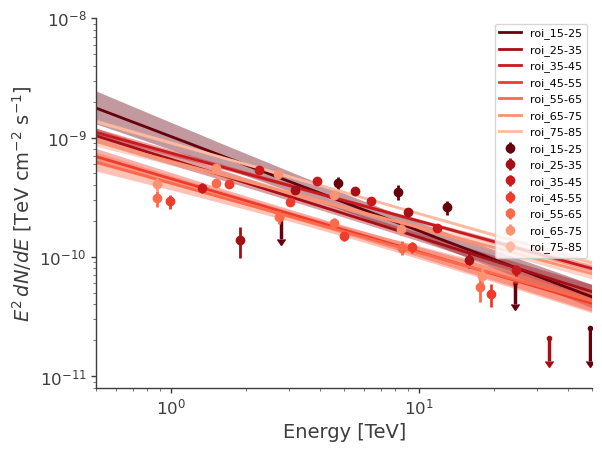

In [16]:
%matplotlib inline
import glob
gc = []
dk = []
dkf = []
de = []
di = []
die = []
den = []
dep = []
dien = []
diep = []
ss = []
ssr= []
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files): #[:7]
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    resultdict = resultsss.get_data_frame()
    gc.append(range(20,360,10)[i])
    dk.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["value"])
    de.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["error"])
    den.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["negative_error"]))
    dep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["positive_error"]))
    di.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["value"])
    die.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["error"])
    dien.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["negative_error"]))
    diep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["positive_error"]))
    try:
        dkf.append(resultsall[i][2][0])
    except:
        resultfile = np.load(f"../res/{region_name}/resultsall.npy")
        dkf = resultfile[9]
    if i < 7:
        # try:
        plot_spectra(
            resultsss,
            sources_to_use=["Diffuse"],
            include_extended=True,
            ene_min=x_Min,
            ene_max=x_Max,
            num_ene=30,
            energy_unit="TeV",
            flux_unit=f"TeV/(s cm2)", #*
            subplot=ax,
            plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i]} #
            )
        try:
            data = my.Draw_spectrum_fromfile(subfolder+"Spectrum_Diffuse.txt", label=name, color=my.red_palette[-(i+1)], subplot=ax, scale=1/dkf[i])
            my.spec2naima(f"./spec_{name}.txt", data)
        except:
            pass
        # except Exception as e:
        #     print(f"Error: {e}")
        #     continue
results=[gc,dk,de,den,dep,di,die,dien,diep, dkf]
np.save(f"../res/{region_name}/resultsall.npy",results)
from threeML.analysis_results import AnalysisResultsSet
resultsall
rrr = [it[0][0].results for it in resultsall]
analysis_set = AnalysisResultsSet(rrr)

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band10-70.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band10-70.pdf",dpi=300)

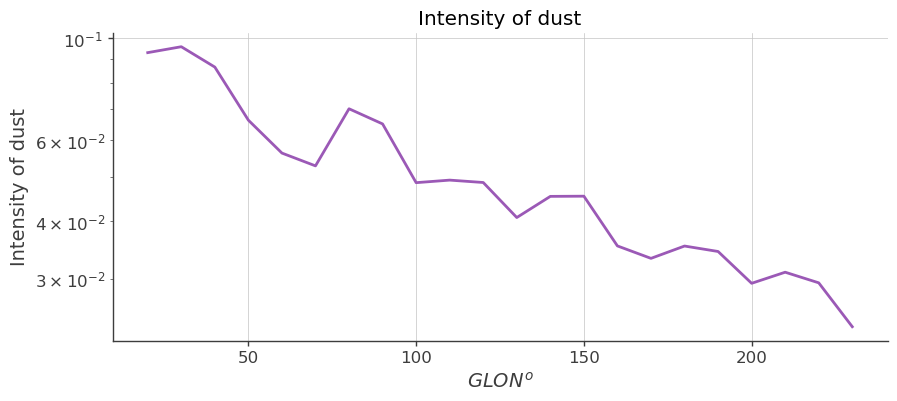

In [4]:
plt.figure(figsize=(10,4)) #
plt.plot(gc, np.array(dkf)) #np.array(den)*1e9, np.array(dep)*1e9 , fmt="o"
plt.yscale("log")
plt.title("Intensity of dust")

plt.ylabel(r"Intensity of dust")
# plt.ylim(1e-7, 1e-4)
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/dust.png",dpi=300)
plt.savefig(f"../res/{region_name}/dust.pdf",dpi=300)

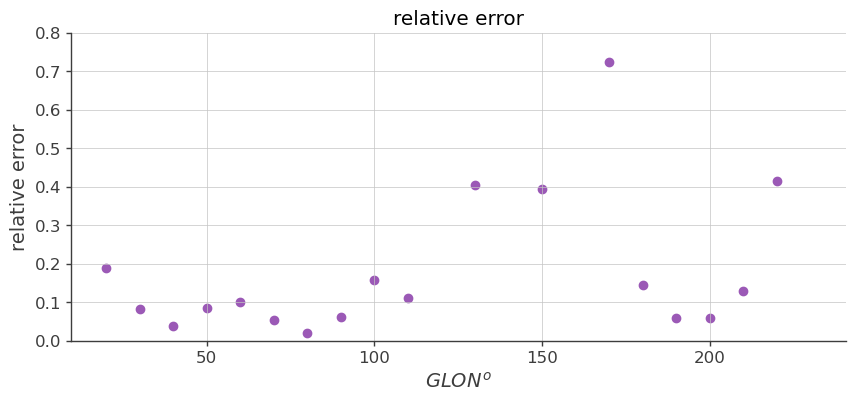

In [15]:
plt.figure(figsize=(10,4)) #
plt.scatter(gc, (np.array(de)*1e9)/(np.array(dk)*1e9), marker="o") #np.array(den)*1e9, np.array(dep)*1e9
# plt.yscale("log")
plt.title("relative error")
plt.ylim(0, 0.8)
plt.ylabel("relative error")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

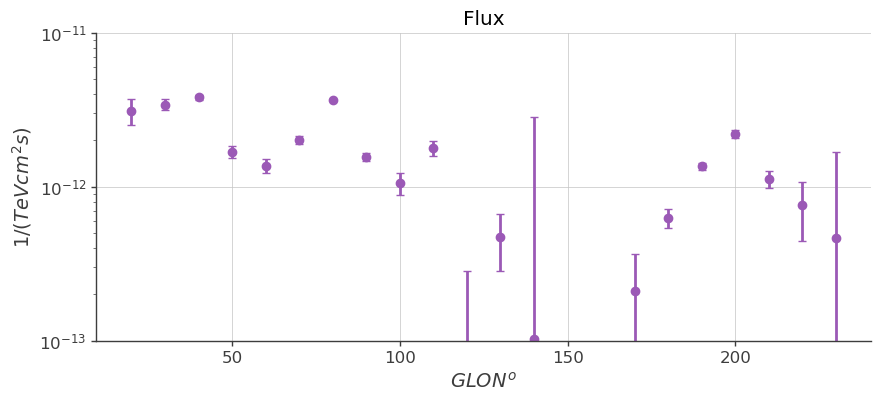

In [5]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9, [np.array(de)*1e9, np.array(de)*1e9], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-13, 1e-11)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

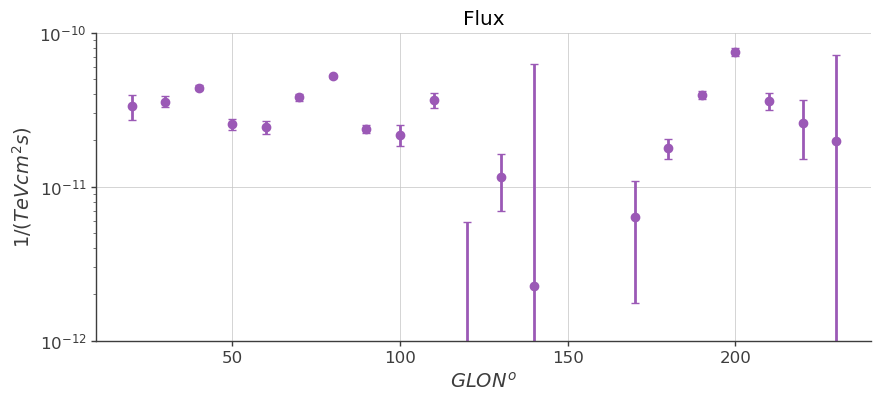

In [6]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9/np.array(dkf), [np.array(de)*1e9/np.array(dkf), np.array(de)*1e9/np.array(dkf)], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-12, 1e-10)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux_fullsky.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux_fullsky.pdf",dpi=300)

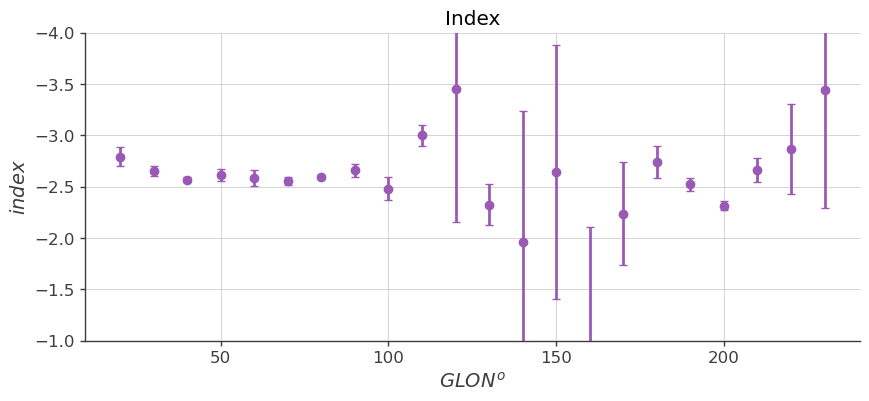

In [7]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, di, [die, die], fmt="o", capsize=3) #dien, diep
plt.ylim(-1,-4)
plt.title("Index")
plt.ylabel(r"$index$")
plt.xlabel(r"$GLON^{o}$")
plt.grid()
plt.savefig(f"../res/{region_name}/index.png",dpi=300)
plt.savefig(f"../res/{region_name}/index.pdf",dpi=300)

In [ ]:
%matplotlib inline
import glob
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files[6:14]):
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    # try:
    plot_spectra(
        resultsss,
        sources_to_use=["Diffuse"],
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit=f"TeV/(s cm2)", #*
        subplot=ax,
        plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i+6]} #
        )
    # except Exception as e:
    #     print(f"Error: {e}")
    #     continue
    

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band70-150.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band70-150.pdf",dpi=300)